# Sistem Rekomendasi Destinasi Wisata Berbasis Collaborative Filtering
<hr>


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!rm -rf data

In [ ]:
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kanchana1990/vehicle-dataset-2024                            Vehicle Dataset 2024                                308KB  2024-05-29 20:02:30            771         28  1.0              
rohit265/credit-card-eligibility-data-determining-factors    Credit Card Eligibility Data: Determining Factors   296KB  2024-05-18 11:31:28           1650         31  1.0              
piterfm/football-soccer-uefa-euro-1960-2024                  Football - Soccer - UEFA EURO, 1960 - 2024           87KB  2024-05-27 19:28:57            725         23  1.0              
hamjashaikh/mental-health-detection-dataset                  Mental Health 

In [ ]:
! kaggle datasets download -d aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 67.1MB/s]


In [ ]:
import zipfile
import os

In [ ]:
local_zip = 'indonesia-tourism-destination.zip'
target_extraction = '/content/data/'
file_check = "dataset"

try:
    if os.path.exists(os.path.join(target_extraction, file_check)):
        print("File Already Extracted")
    else:
        zip_ref = zipfile.ZipFile(local_zip, 'r')
        zip_ref.extractall(target_extraction)

except FileNotFoundError:
    print('Zip File Not Found!')

## 1. Mengimpor Library Python yang Dibutuhkan

In [ ]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [ ]:
# Upload semua dataset yang dipakai
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3. Data Understanding

### 3.1 Menyiapkan Data

In [ ]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('data/tourism_rating.csv')
place = pd.read_csv('data/tourism_with_id.csv')
user = pd.read_csv('data/user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [ ]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [ ]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

## Data Category

#### 3.2.2. Data rating

In [ ]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [ ]:
# Merubah data rating agar hanya berisi rating pada tempat wisata

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


In [ ]:


rating.shape

(10000, 3)

#### 3.2.3. Data user

In [ ]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
18,2,"Bekasi, Jawa Barat",21
345,3,"Cirebon, Jawa Barat",23
62,4,"Bekasi, Jawa Barat",21
63,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Melihat dataset user yang pernah memberi rating pada wisata di Kota Bandung

user.shape

(300, 3)

## 4. Eksplorasi Data

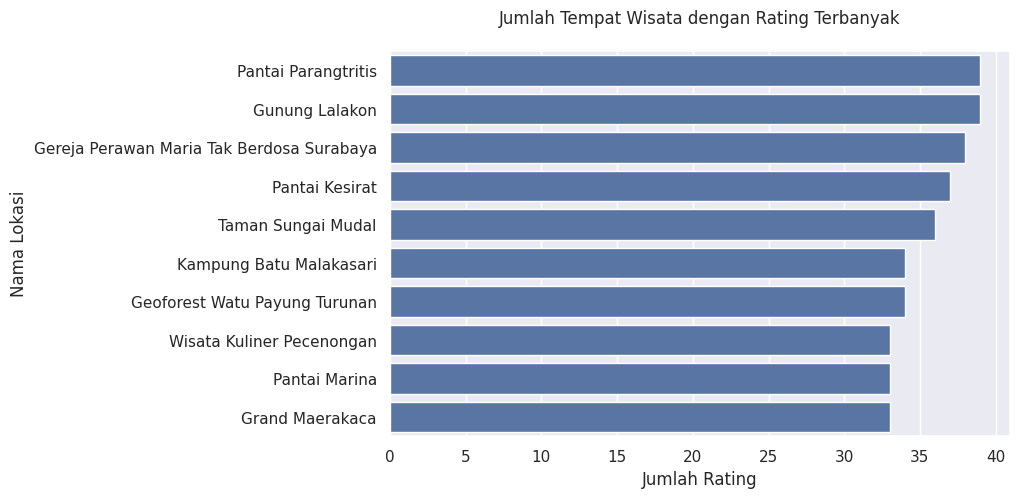

In [ ]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10.columns = ['Place_Id', 'count']  # Rename columns for easier access
top_10 = pd.merge(top_10, place[['Place_Id', 'Place_Name']], how='left', on='Place_Id')


# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8, 5))
sns.barplot(x='count', y='Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Nama Lokasi')
plt.xlabel('Jumlah Rating')
plt.show()

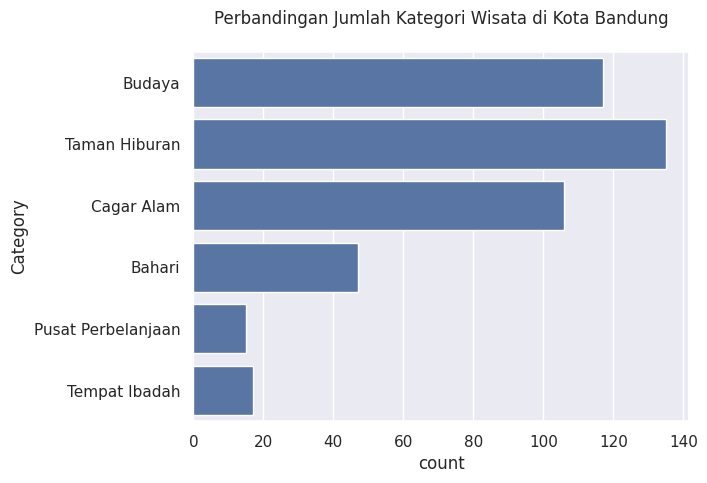

In [ ]:
# Membuat visualisasi jumlah kategori wisata

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata di Kota Bandung', pad=20)
plt.show()

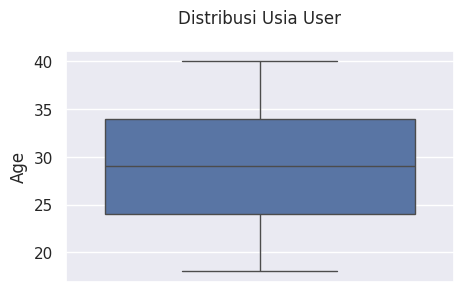

In [ ]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

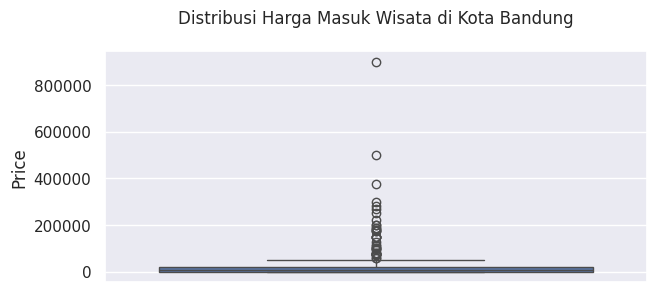

In [ ]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata di Kota Bandung', pad=20)
plt.show()

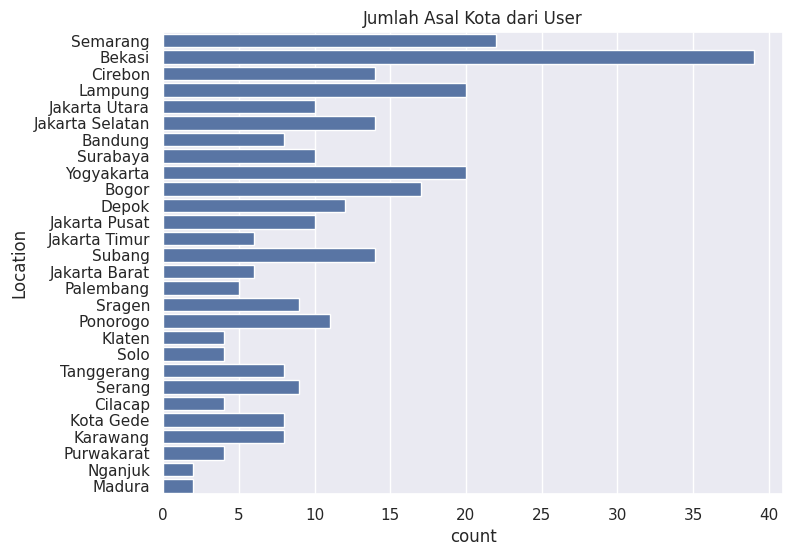

In [ ]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [ ]:
# Membaca dataset untuk dilakukan encoding

df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [ ]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### 5.2.2. Encoding dan Mapping Kolom User

In [ ]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

#### 5.2.3. Encoding dan Mapping Kolom Place

In [ ]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)
print(df)

      User_Id  Place_Id  Place_Ratings  user  place
0          36         1              4     0      0
1          38         1              2     1      0
2          64         1              2     2      0
3          74         1              2     3      0
4          86         1              4     4      0
...       ...       ...            ...   ...    ...
9995      284       437              5   299    436
9996      288       437              1    69    436
9997      288       437              4    69    436
9998      297       437              4   122    436
9999      298       437              3   192    436

[10000 rows x 5 columns]


### 5.3. Melihat Gambaran Data untuk Pemodelan

In [ ]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Place: 437, Min Rating: 1.0, Max Rating: 5.0


In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,user,place
6252,203,274,2.0,36,273
4684,126,206,5.0,112,205


## 6. Pemodelan Machine Learning

### 6.1. Membagi data train dan test

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### 6.2. Menyiapkan Model

#### Deklarasi Fungsi

In [ ]:
def dict_encoder(col, data):
    unique_val = data[col].unique().tolist()
    val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
    val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
    return val_to_val_encoded, val_encoded_to_val

def encode_data(df):
    user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id', df)
    df['user'] = df['User_Id'].map(user_to_user_encoded)

    place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id', df)
    df['place'] = df['Place_Id'].map(place_to_place_encoded)

    return df, user_to_user_encoded, place_to_place_encoded


#### Membaca, Mengolah, dan Mempersiapkan Data:

In [ ]:

# Membaca data dan melakukan encoding
df_encoded, user_to_user_encoded, place_to_place_encoded = encode_data(rating)

# Mendapatkan jumlah user dan place
num_users, num_places = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
df_encoded['Place_Ratings'] = df_encoded['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df_encoded['Place_Ratings']), max(df_encoded['Place_Ratings'])

#### Pembagian Data dan Persiapan untuk Pelatihan:

In [ ]:
# Mengacak dataset
df_encoded = df_encoded.sample(frac=1, random_state=42)

# Membuat variabel x dan y untuk pelatihan model
x = df_encoded[['user', 'place']].values
y = df_encoded['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df_encoded.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)


#### Inisialisasi dan Pelatihan Model:

In [ ]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

def create_ncf_model(num_users, num_items, embedding_size=50, dense_layers=[32, 16]):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_size, name='item_embedding')(item_input)

    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)

    concat = Concatenate()([user_flatten, item_flatten])

    for units in dense_layers:
        concat = Dense(units, activation='relu')(concat)

    output = Dense(1, activation='sigmoid')(concat)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model
print(f'Number of Users: {num_users}, Number of Places: {num_places}, Min Rating: {min_rating}, Max Rating: {max_rating}')

# Inisialisasi model
model = create_ncf_model(num_users, num_places)
model.summary()
# Callbacks untuk pelatihan
early_stopping = callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10,  # Peningkatan patience untuk early stopping
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_mae',
    save_best_only=True
)

# Pelatihan model
history = model.fit(
    x=[x_train[:, 0], x_train[:, 1]],
    y=y_train,
    batch_size=64,
    epochs=100,  # Peningkatan jumlah epoch untuk pelatihan
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    callbacks=[early_stopping, model_checkpoint]
)

Number of Users: 300, Number of Places: 437, Min Rating: 1.0, Max Rating: 5.0
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                15000     ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 50)                21850     ['item_input[0][0]']          
              

#### Visualisasi Hasil Pelatihan

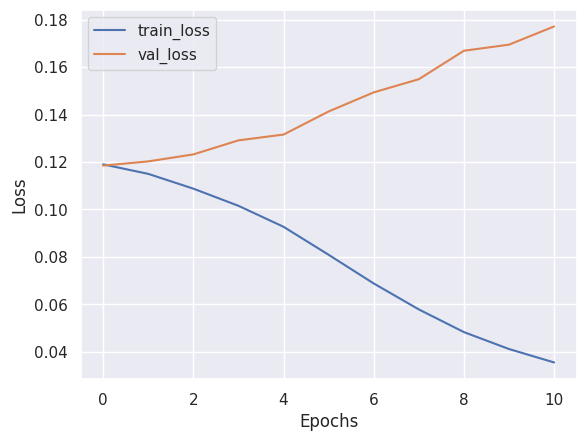

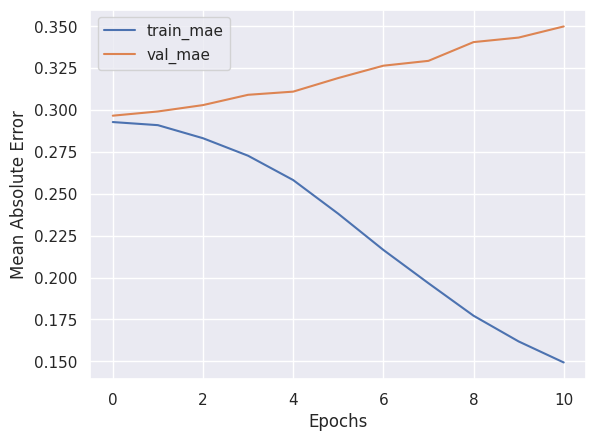

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


## hasil rekomendasi untuk user

In [ ]:
# Buat DataFrame baru yang berisi semua pasangan pengguna-tempat yang mungkin
all_users = np.array(list(user_to_user_encoded.values()))
all_places = np.array(list(place_to_place_encoded.values()))
all_user_place = np.array(np.meshgrid(all_users, all_places)).T.reshape(-1, 2)
df_all_user_place = pd.DataFrame(all_user_place, columns=['user', 'place'])

# Gunakan model yang sudah dilatih untuk membuat prediksi rating
predictions = model.predict([df_all_user_place['user'], df_all_user_place['place']])

# Tambahkan prediksi rating ke DataFrame
df_all_user_place['predicted_rating'] = predictions.flatten()

# Urutkan hasil prediksi berdasarkan rating tertinggi
df_recommendations = df_all_user_place.sort_values(by='predicted_rating', ascending=False)

# Tampilkan hasil rekomendasi dalam bentuk DataFrame
print(df_recommendations.head(10))


4097/4097 [==============================] - 7s 2ms/step
        user  place  predicted_rating
84756    193    415          0.624039
84457    193    116          0.612764
84377    193     36          0.611434
24887     56    415          0.610724
84662    193    321          0.609755
117531   268    415          0.609647
84376    193     35          0.608589
84777    193    436          0.606739
84640    193    299          0.606555
21391     48    415          0.605586


In [ ]:
# Group the recommendations by place and sort them by predicted rating in descending order
grouped_recommendations = df_recommendations.groupby('place').apply(lambda x: x.sort_values(by='predicted_rating', ascending=False))

# Print the top 10 recommendations with the highest rating, considering only one recommendation per place
print("Top 10 Cultural Recommendations:")
seen_places = set()
recommendations_count = 0
for index, row in grouped_recommendations.iterrows():
    place_id = place_encoded_to_place[row['place']]
    if place_id not in seen_places:
        place_details = place[place['Place_Id'] == place_id]
        category = place_details['Category'].iloc[0]

        # Check if the place belongs to the 'Culture' category
        if category == 'Cagar Alam':
            place_name = place_details['Place_Name'].iloc[0]
            price = place_details['Price'].iloc[0]
            rating = place_details['Rating'].iloc[0]

            print(f"Place ID: {place_id}")
            print(f"Place Name: {place_name}")
            print(f"Category: {category}")
            print(f"Price: {price}")
            print(f"Rating: {rating}")
            print("\n")

            seen_places.add(place_id)
            recommendations_count += 1

            if recommendations_count >= 10:
                break


Top 10 Cultural Recommendations:
Place ID: 7
Place Name: Kebun Binatang Ragunan
Category: Cagar Alam
Price: 4000
Rating: 4.5


Place ID: 31
Place Name: Wisata Alam Mangrove Angke
Category: Cagar Alam
Price: 25000
Rating: 4.3


Place ID: 67
Place Name: Margasatwa Muara Angke
Category: Cagar Alam
Price: 25000
Rating: 4.2


Place ID: 71
Place Name: Cibubur Garden Diary (Cibugary)
Category: Cagar Alam
Price: 50000
Rating: 4.5


Place ID: 93
Place Name: Gembira Loka Zoo
Category: Cagar Alam
Price: 60000
Rating: 4.5


Place ID: 131
Place Name: Watu Lumbung
Category: Cagar Alam
Price: 5000
Rating: 4.3


Place ID: 132
Place Name: Air Terjun Kedung Pedut
Category: Cagar Alam
Price: 20000
Rating: 4.5


Place ID: 137
Place Name: Wisata Alam Kalibiru
Category: Cagar Alam
Price: 20000
Rating: 4.4


Place ID: 139
Place Name: Puncak Gunung Api Purba - Nglanggeran
Category: Cagar Alam
Price: 10000
Rating: 4.7


Place ID: 141
Place Name: Bunker Kaliadem Merapi
Category: Cagar Alam
Price: 3000
Rating: 4



# save model





In [ ]:
# Menyimpan model ke file
model.save('model.h5')


# API untuk Prediksi

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf

app = Flask(__name__)

# Muat model terlatih
model = tf.keras.models.load_model('model.h5')

# Encoder dictionaries
user_to_user_encoded = { ... }  # Isi dengan dictionary yang digunakan untuk encoding user
place_to_place_encoded = { ... }  # Isi dengan dictionary yang digunakan untuk encoding place

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    user_id = data['user_id']
    place_id = data['place_id']

    user_encoded = user_to_user_encoded.get(user_id, None)
    place_encoded = place_to_place_encoded.get(place_id, None)

    if user_encoded is None or place_encoded is None:
        return jsonify({'error': 'User or Place not found'}), 400

    prediction = model.predict([[user_encoded], [place_encoded]])
    rating = prediction[0][0]

    return jsonify({'rating': rating})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8080)


 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 8080 is in use by another program. Either identify and stop that program, or start the server with a different port.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/serving.py", line 750, in __init__
    self.server_bind()
  File "/usr/lib/python3.10/http/server.py", line 137, in server_bind
    socketserver.TCPServer.server_bind(self)
  File "/usr/lib/python3.10/socketserver.py", line 466, in server_bind
    self.socket.bind(self.server_address)
OSError: [Errno 98] Address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-107-33bce6ef4015>", line 31, in <cell line: 30>
    app.run(host='0.0.0.0', port=8080)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1191, in run
    run_simple(t.cast(str, host), port, self, **options)
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/serving.p

TypeError: object of type 'NoneType' has no len()